In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Set a random seed for reproducibility
torch.manual_seed(42)

In [2]:
from differential_model import *
from generate_data import *
from physical_model import *
from plot import *

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")


No GPU available, using CPU.


In [4]:
# System parameters
m = 1.0  # mass
c = 0.2  # damping coefficient
k = 100.0  # spring constant

# Time
t0 = 0
tf = 10

# Frequncy
fs = 50

# tspan
tspan = torch.arange(t0, tf, 1/fs)
nt = tf * fs

In [5]:
# Initialize the Spring_Model on the GPU
spring_model_gt = Spring_Model(m, c, k, t0, tf, fs, device, [1000, 3, 0, 2, 0])
simulator = Spring_Model(m, c, k, t0, tf, fs, device, [0, 3, 1, 2, 1])

In [12]:
sig_u = [1, 3, 5]
data_gt = torch.zeros(nt, len(sig_u), 2)
data_simulated = torch.zeros(nt, len(sig_u), 2)
u_data = torch.zeros(nt, len(sig_u))

for i in range(len(sig_u)):
    u = generate_u(sig_u[i], nt, fs, device)
    data_gt[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated[:, i, :] = generate_date(simulator, u).T
    u_data[:, i] = u


In [13]:
initial_error = torch.mean((data_gt -data_simulated) ** 2)
initial_error

tensor(0.1497)

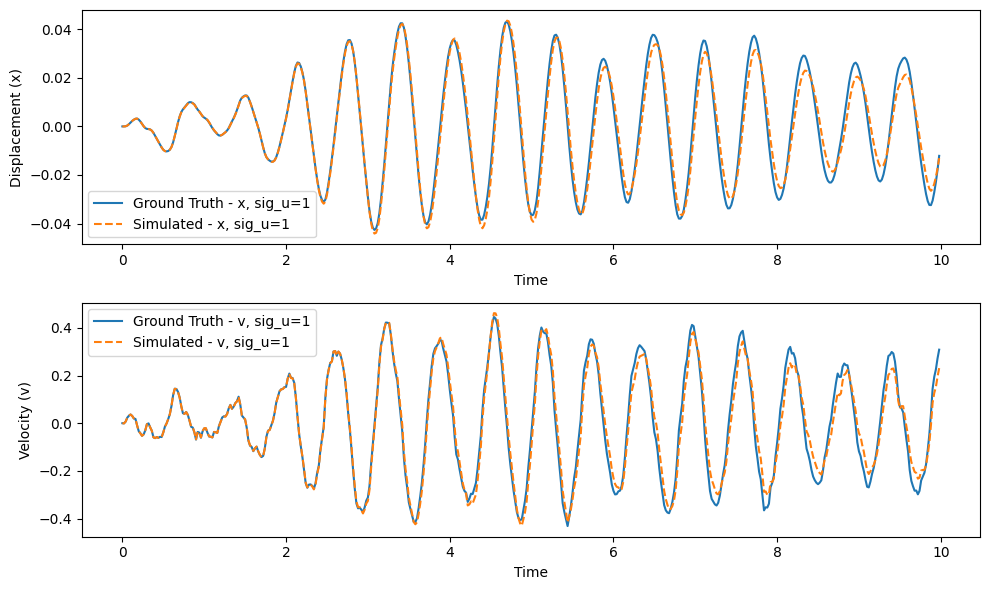

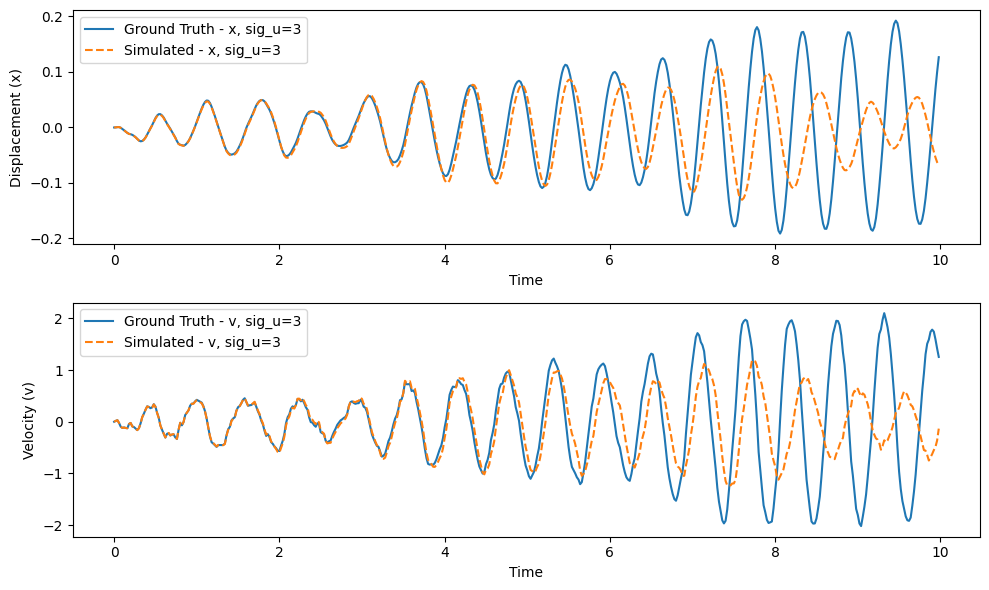

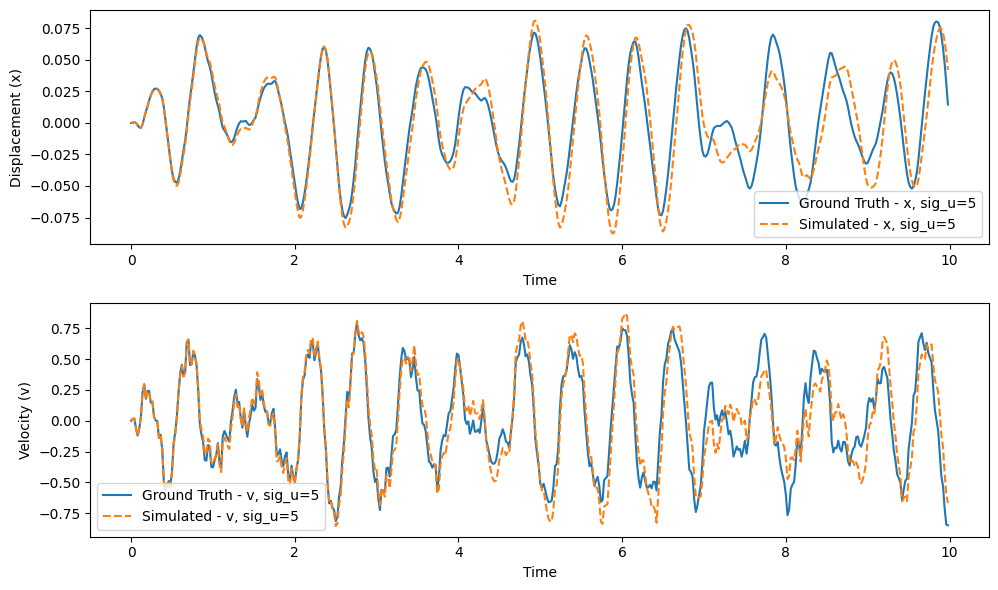

In [14]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u[i]}')
    plt.plot(time_values, data_simulated[:, i, 0], label=f'Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u[i]}')
    plt.plot(time_values, data_simulated[:, i, 1], label=f'Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
class DifferentialSolver:
    def __init__(self, model, optimizer, criterion=nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, simulation, target_solution, u, max_epochs=100, msteps=2, batch_size=1000):
        display_at = max(1, max_epochs / 20)
        losses = []
        N = target_solution.shape[0]
        feasible_range = N - msteps - 1
        std_data = torch.std(target_solution, axis = 0).T    #torch.Size([2, 5])

        for sim in range(max_epochs):
            self.optimizer.zero_grad()
            loss = 0

            for batch in range(batch_size):
                r = np.random.randint(feasible_range)
                yi = target_solution[r, :].T # torch.Size([2, 5])

                for m in range(msteps):
                    u_m = u[r + m: r + m + 1, :] # torch.Size([1, 5])
                    yi = simulation.step(yi, u_m)
                    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
                    dy_i = self.model(input).T # torch.Size([2, 5])
                    yi = yi + dy_i
                    loss += self.criterion(yi.div(std_data) , target_solution[r + m + 1, :].T.div(std_data)) / msteps

            loss /= batch_size
            loss.backward(retain_graph=True)
            self.optimizer.step()
            losses.append(loss.item())

            if sim % display_at == 0:
                print(sim, "Training Loss:", loss.item())

        return losses

In [16]:
# Create a neural network model
model = NeuralNet(3, [16, 32, 64, 32, 16], 2, nn.ReLU(), device)

# Create a DifferentialSolver and train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
solver = DifferentialSolver(model, optimizer)

0 Training Loss: 37.03617477416992
12500 Training Loss: 0.00010816944995895028
25000 Training Loss: 0.00018327089492231607
37500 Training Loss: 0.00021127218496985734
50000 Training Loss: 6.441690493375063e-05
62500 Training Loss: 0.00036180770257487893
75000 Training Loss: 4.982992322766222e-05
87500 Training Loss: 0.00232337205670774
100000 Training Loss: 3.142601781291887e-05
112500 Training Loss: 2.4390286853304133e-05
125000 Training Loss: 2.068848698399961e-05
137500 Training Loss: 3.428506897762418e-05
150000 Training Loss: 5.204878470976837e-05
162500 Training Loss: 1.1439570698712487e-05
175000 Training Loss: 1.0953695891657844e-05
187500 Training Loss: 1.0180557183048222e-05
200000 Training Loss: 1.9550094293663278e-05
212500 Training Loss: 5.761342981713824e-05
225000 Training Loss: 1.4970420124882367e-05
237500 Training Loss: 8.174552931450307e-06


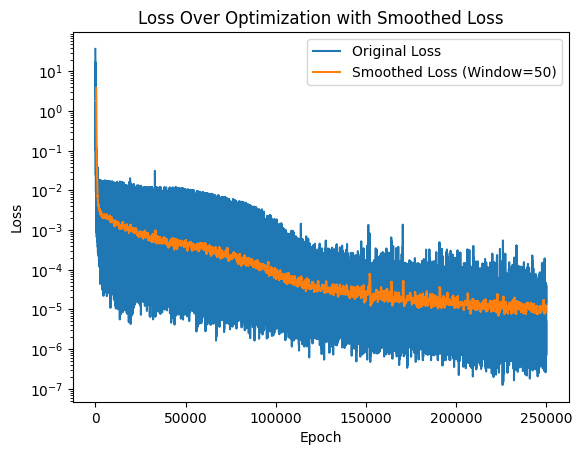

In [17]:
losses = solver.train(simulator, target_solution=data_gt, u = u_data, max_epochs=250000, msteps=3, batch_size=1)
plot_losses(losses, 500)

In [18]:
data_simulated_NN = torch.zeros(nt, len(sig_u), 2)
yi = data_simulated_NN[0, :].T

for m in range(nt - 1):
    u_m = u_data[m : m + 1, :] # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
    dy_i = solver.model(input).T # torch.Size([2, 5])
    yi = yi + dy_i
    data_simulated_NN[m + 1, :] = yi.T

final_error = torch.mean((data_gt -data_simulated_NN) ** 2)
final_error

tensor(0.0001, grad_fn=<MeanBackward0>)

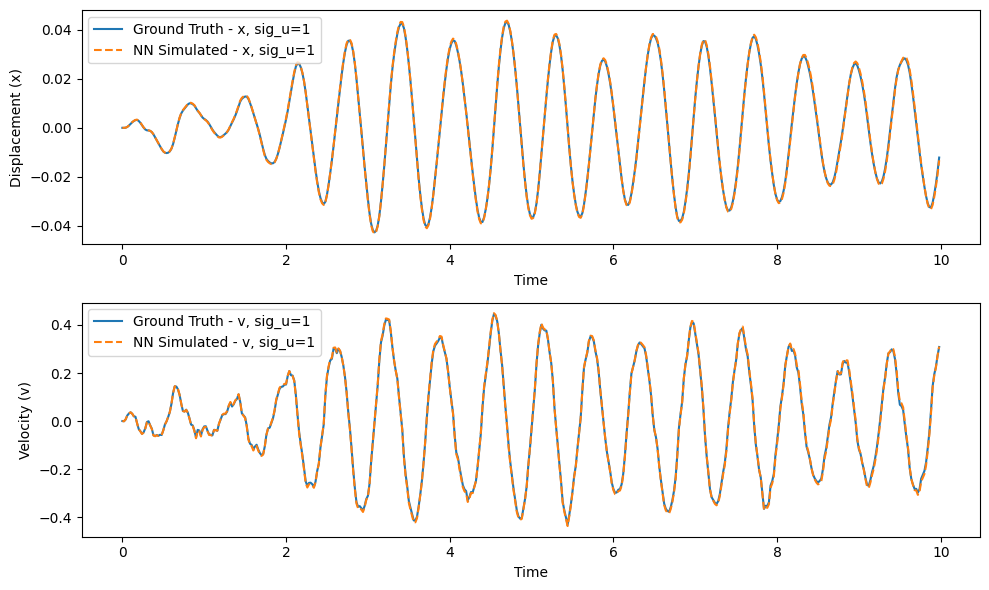

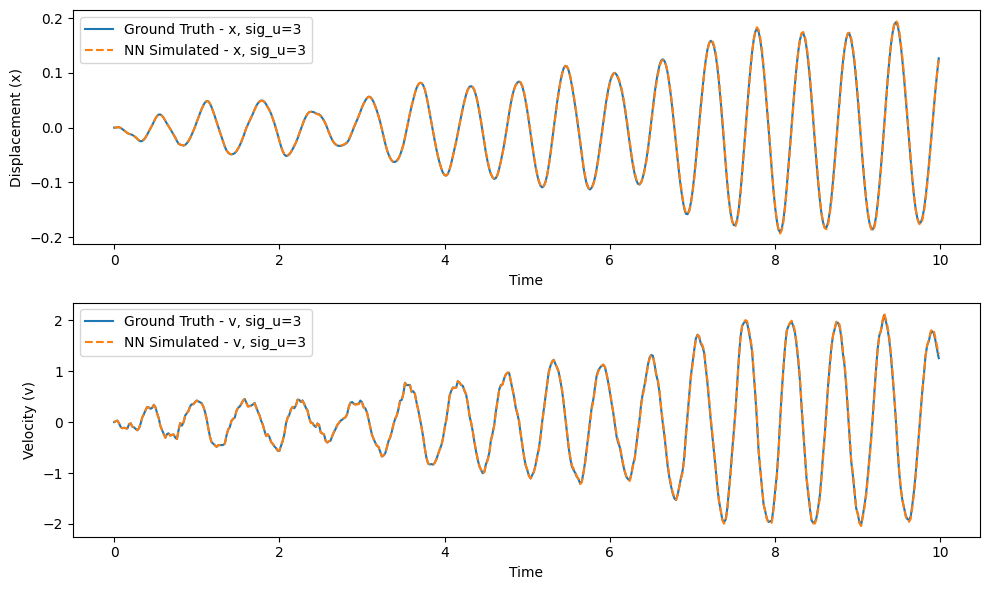

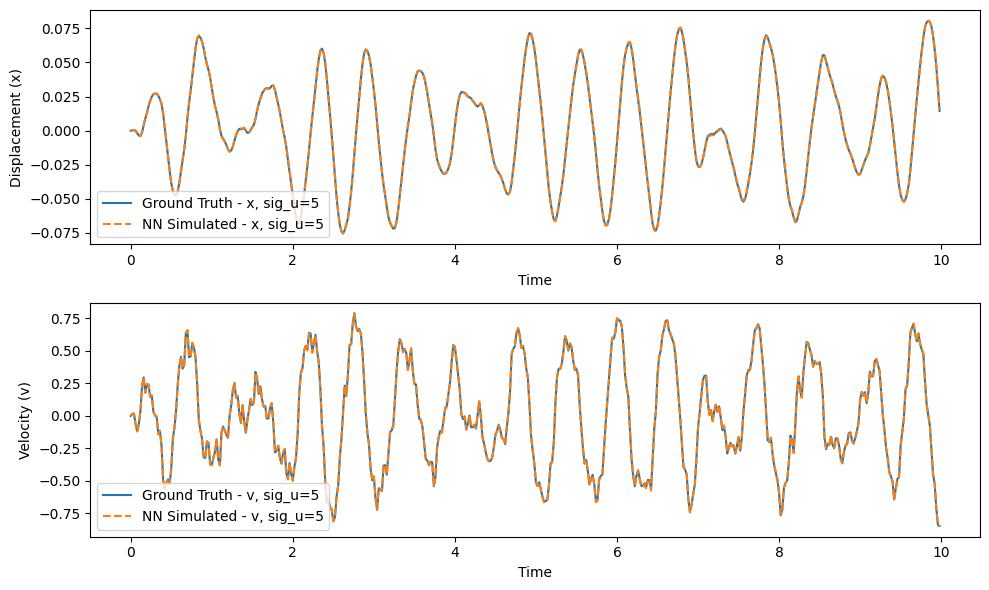

In [19]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u[i]}')
    # plt.plot(time_values, data_simulated[:, i, 0], label=f'Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, 0], label=f'NN Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u[i]}')
    # plt.plot(time_values, data_simulated[:, i, 1], label=f'Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, 1], label=f'NN Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
sig_u_test = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.4, 6, 6.5, 7]
data_gt_test = torch.zeros(nt, len(sig_u_test), 2)
data_simulated_test = torch.zeros(nt, len(sig_u_test), 2)
data_simulated_NN_test = torch.zeros(nt, len(sig_u_test), 2)
u_data_test = torch.zeros(nt, len(sig_u_test))

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], nt, fs, device)
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated_test[:, i, :] = generate_date(simulator, u).T
    u_data_test[:, i] = u

yi = data_simulated_NN_test[0, :].T
for m in range(nt - 1):
    u_m = u_data_test[m : m + 1, :] # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
    dy_i = solver.model(input).T # torch.Size([2, 5])
    yi = yi + dy_i
    data_simulated_NN_test[m + 1, :] = yi.T

In [21]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
initial_error_test, final_error_test

(tensor(0.4080), tensor(0.2217, grad_fn=<MeanBackward0>))

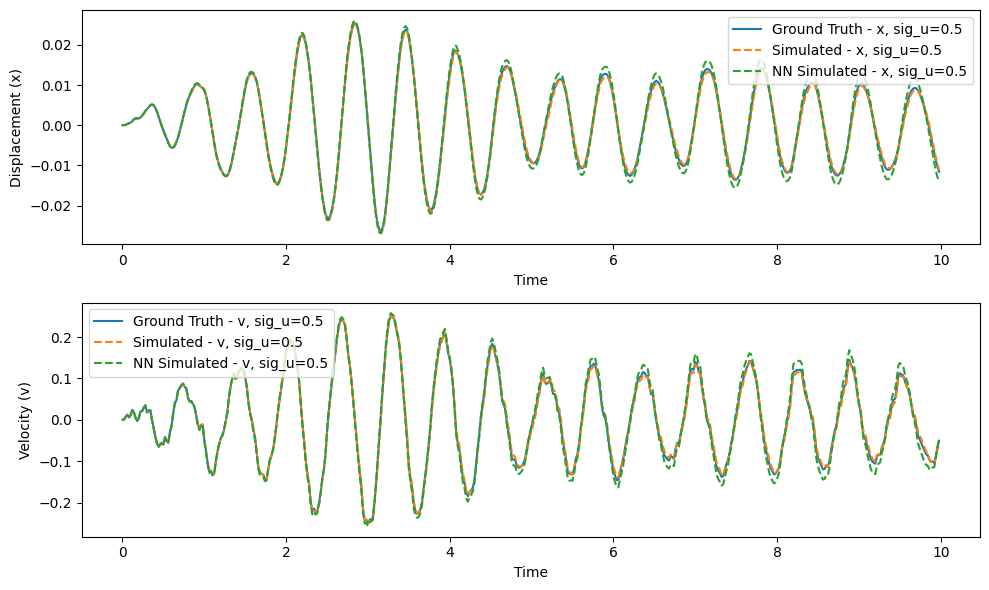

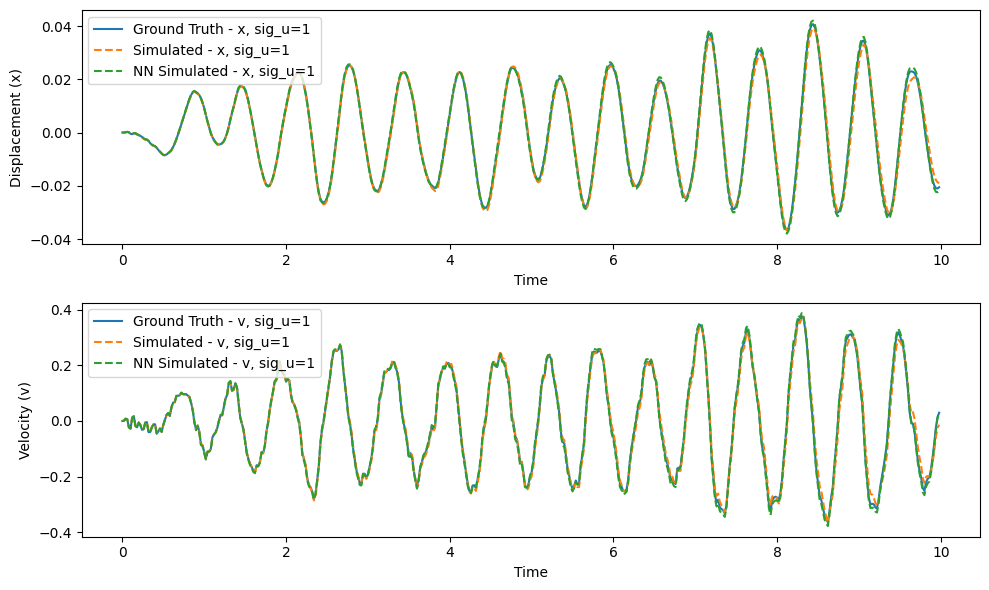

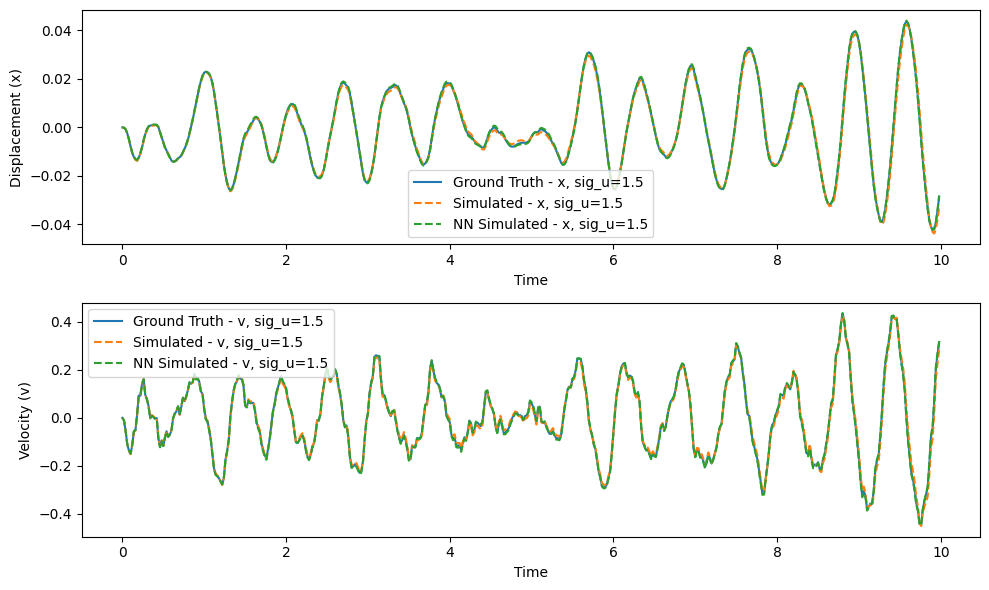

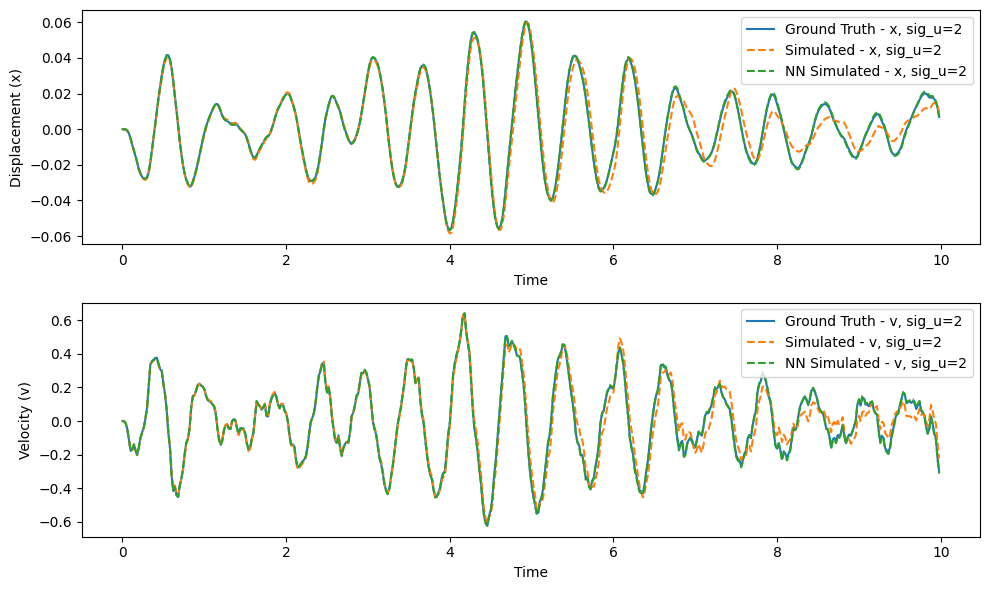

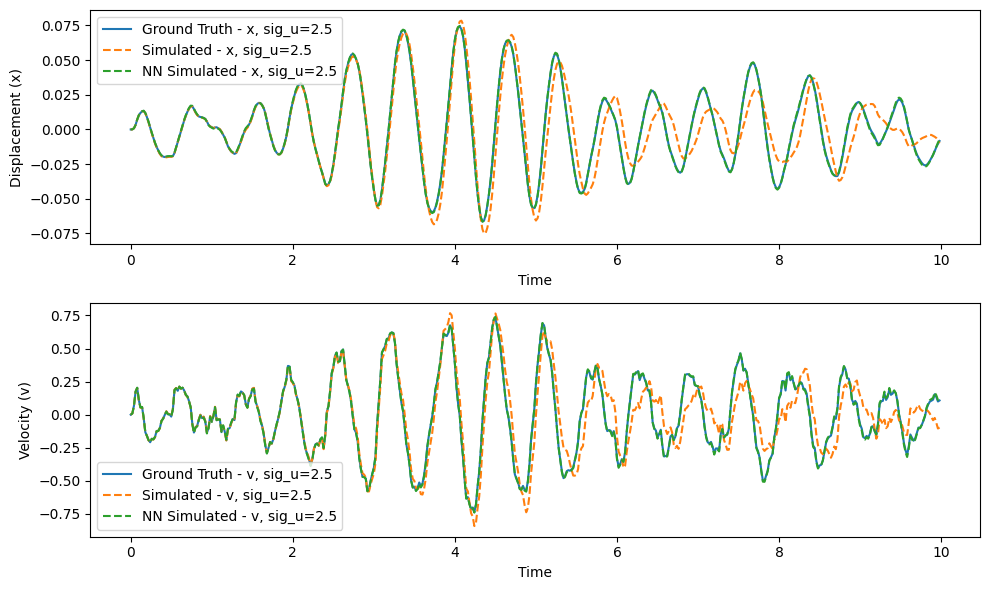

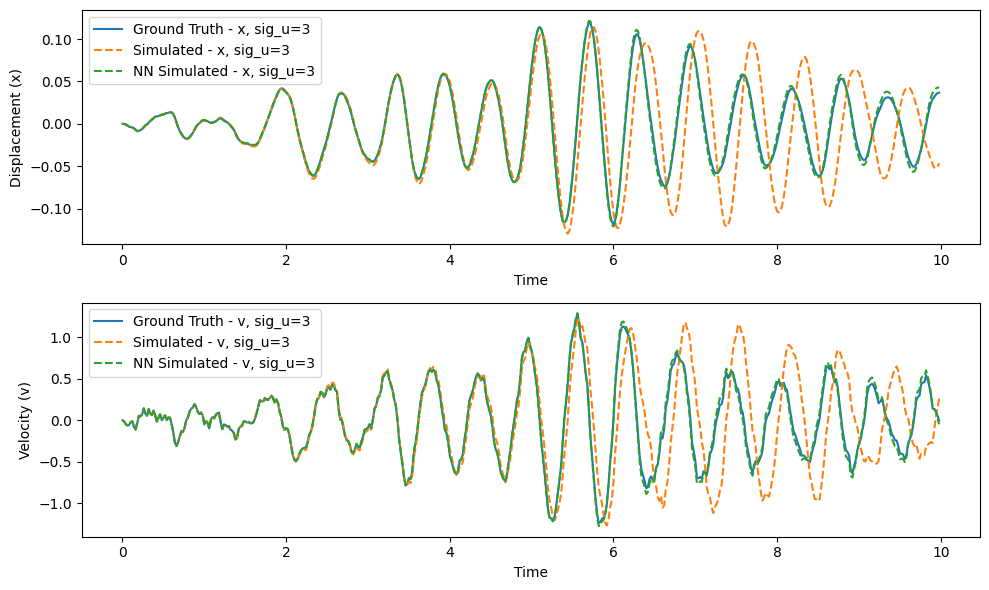

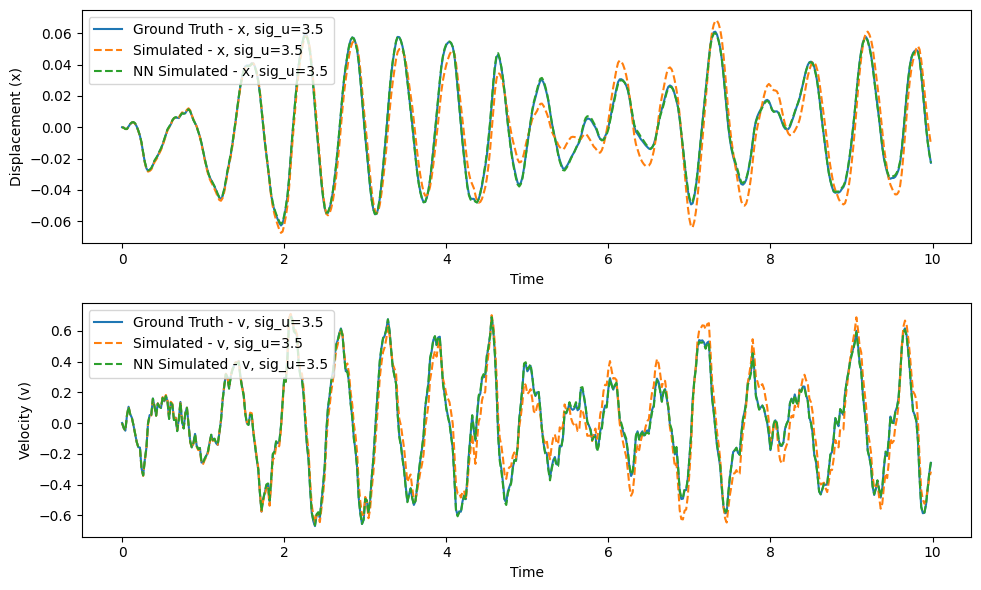

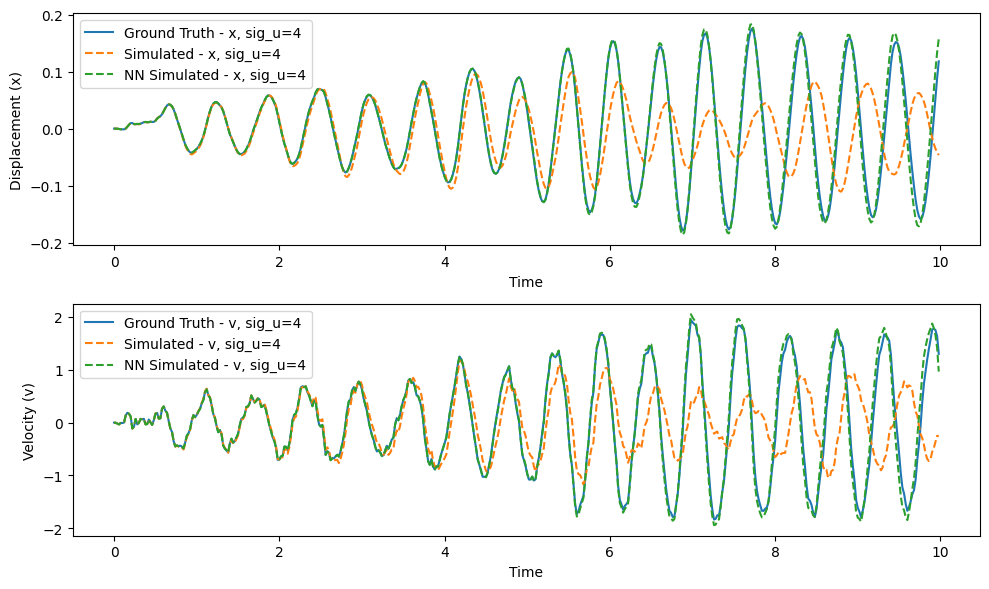

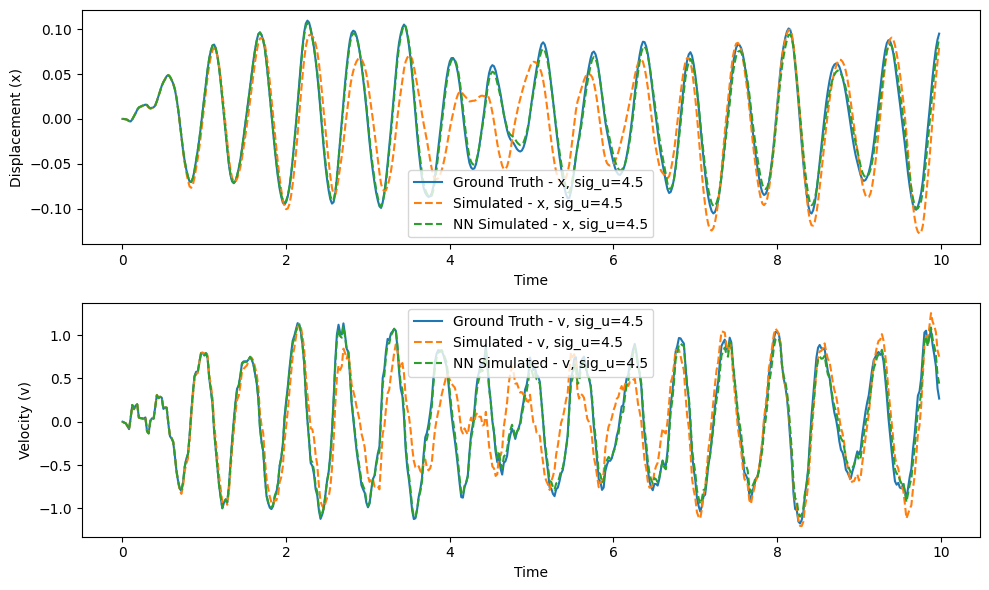

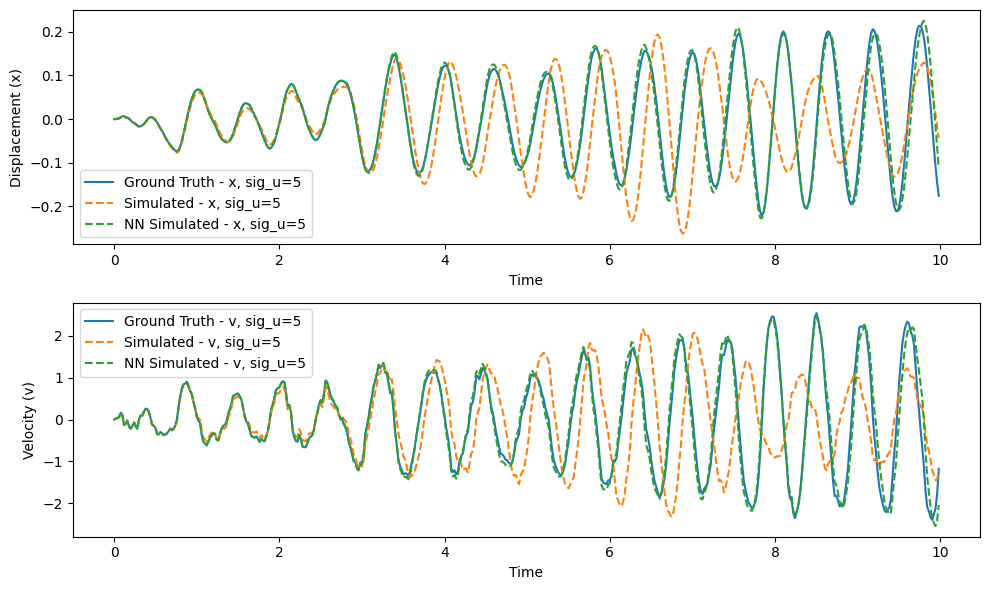

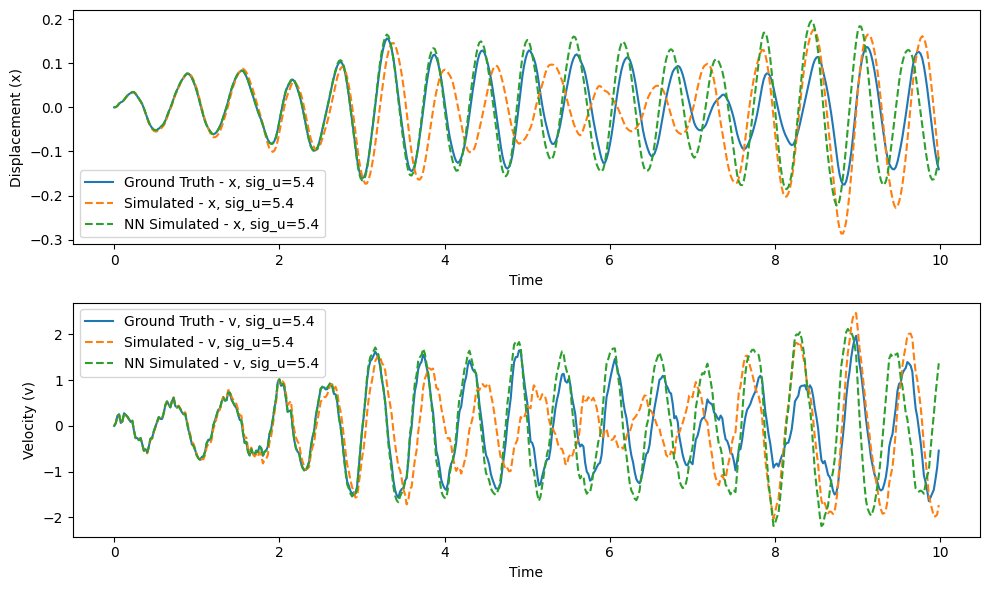

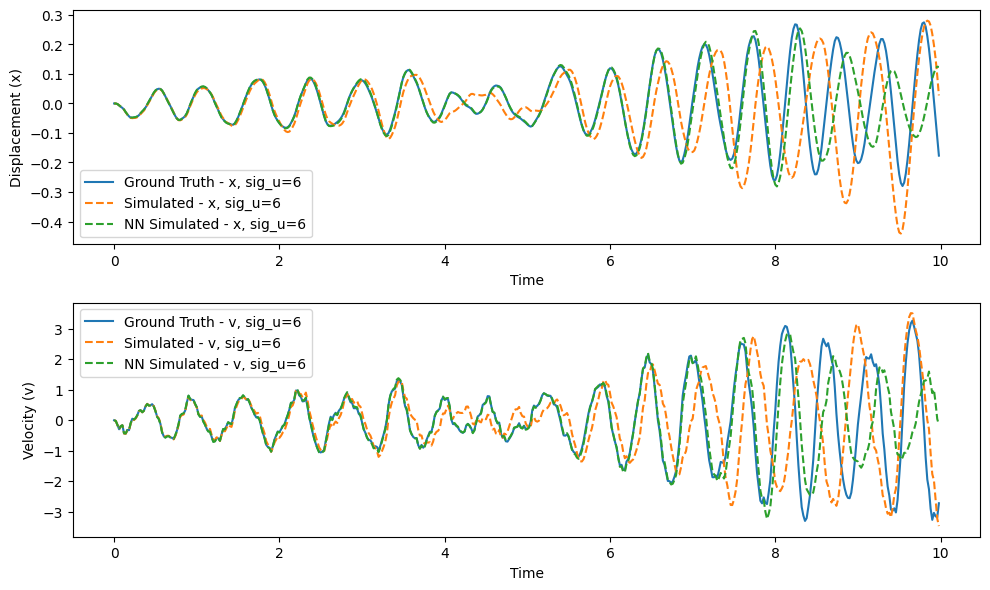

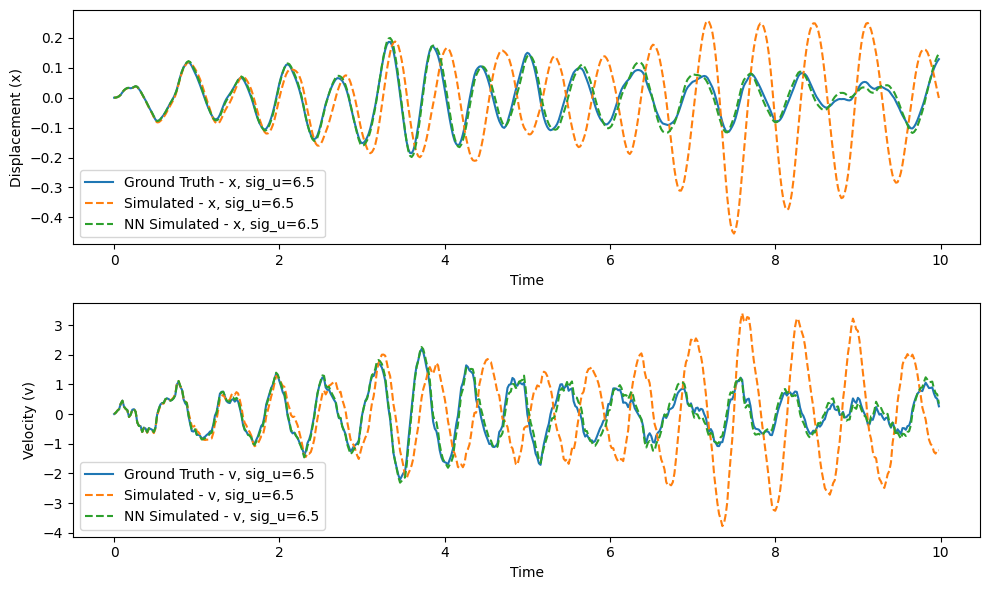

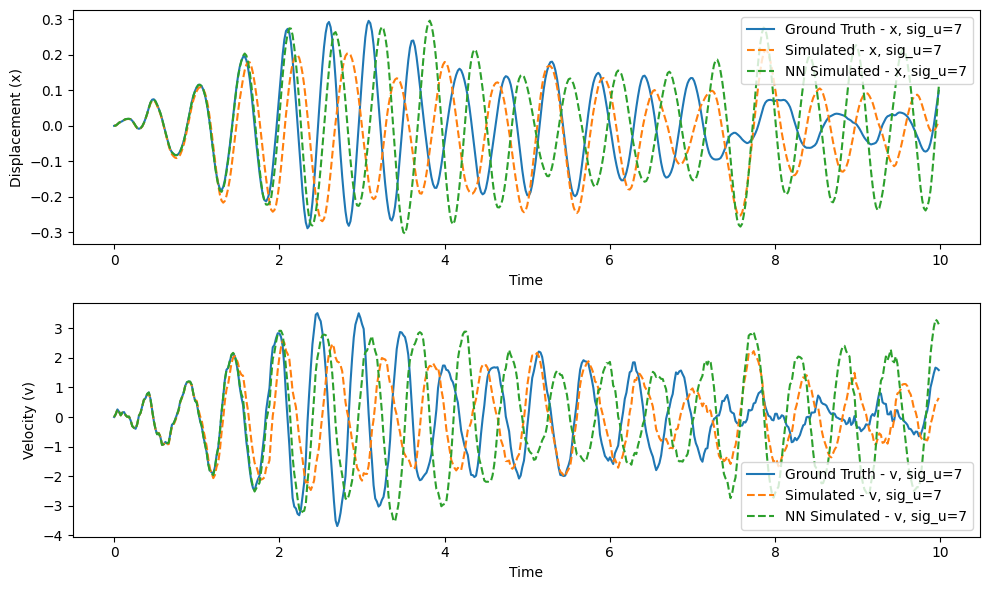

In [22]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u_test)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt_test[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u_test[i]}')
    plt.plot(time_values, data_simulated_test[:, i, 0], label=f'Simulated - x, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 0], label=f'NN Simulated - x, sig_u={sig_u_test[i]}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt_test[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u_test[i]}')
    plt.plot(time_values, data_simulated_test[:, i, 1], label=f'Simulated - v, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 1], label=f'NN Simulated - v, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
# Save the parameters of the model
torch.save(model.state_dict(), 'non_linear_model_parameters_m3.pth')